import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
**How many clusters of birthplaces emerge?**

# Imports

In [1]:
import warnings
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import pandas
import geopandas as gpd
from shapely.geometry import shape, Point
import pandas as pd
import numpy as np
from numpy import savetxt
from functions import *

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [2]:
arena_df = pd.read_csv("data/arenas_w_locations.csv", index_col=0)
arena_gdf = gpd.GeoDataFrame(
            arena_df, geometry=gpd.points_from_xy(arena_df.Lng, arena_df.Lat))
us_can_gdf = gpd.read_file("data/full_us_can_geometry.geojson")

## Data Engineering

In [3]:
# just arena coords
arena_coords = arena_df[['Team_name', 'Lat', 'Lng']]

# Clustergram

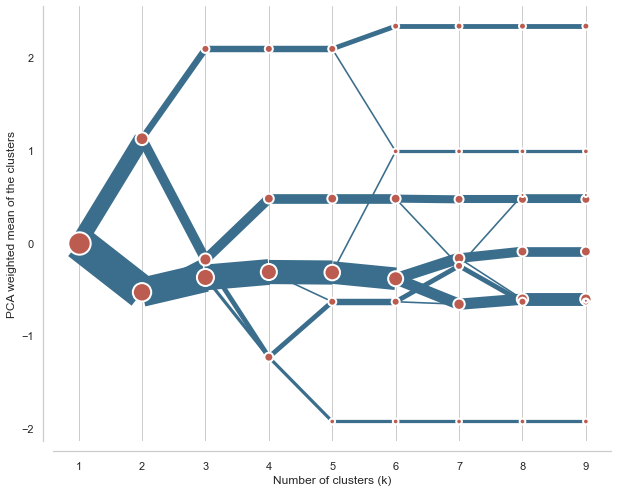

In [5]:
data = scale(arena_coords.drop(columns=['Team_name']))
cgram = fit_plot_clustergram(data)

## Analyzing the optimal number of clusters

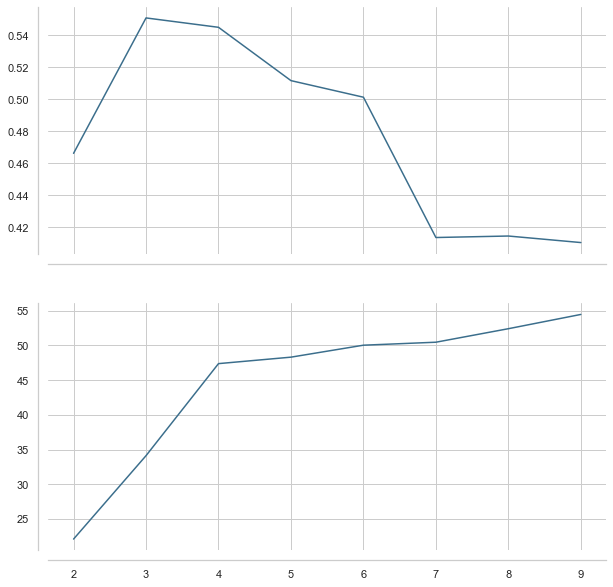

In [6]:
evaluate_num_of_clusters(cgram)

**3 or 4 clusters looks optimal**. Therefore, when we use a clustering algorithm (e.g.: Kmeans), we know the number of clusters for it to create.

# Cluster the data - Kmeans

## No minimum size

In [6]:
# adjusting the data to be an array
X = np.array(arena_coords[['Lat', 'Lng']])

# applying Kmeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# adding labels to player_gdf
arena_gdf['arena_cluster'] = kmeans.labels_

kmeans.cluster_centers_

array([[  39.58365   ,  -77.51950625],
       [  40.93657778, -115.68338889],
       [  40.71575   ,  -91.95156667]])

## Results of clustering the data in MinSizeKmeans

In [7]:
# prepping the data 
# savetxt('data/arena_coords.data', X, delimiter='    ')

In [8]:
# importing cluster assignments 
# MADE USING https://github.com/Behrouz-Babaki/MinSizeKmeans
## NOTE: has 4 clusters to match number of NHL divisions
f = open("data/arena_min_kmeans4.txt", 'r')
mink_clusters4 = [x[0] for x in f.readlines()]

In [9]:
# attaching to data 
arena_gdf['arena_cluster_mink4'] = mink_clusters4

In [10]:
# importing cluster assignments 
## NOTE: has 4 clusters to match number of NHL divisions
f = open("data/arena_min_kmeans3.txt", 'r')
mink_clusters3 = [x[0] for x in f.readlines()]

In [11]:
# attaching to data 
arena_gdf['arena_cluster_mink3'] = mink_clusters3

# Plotting Data

## No minimum size of cluster

<AxesSubplot:>

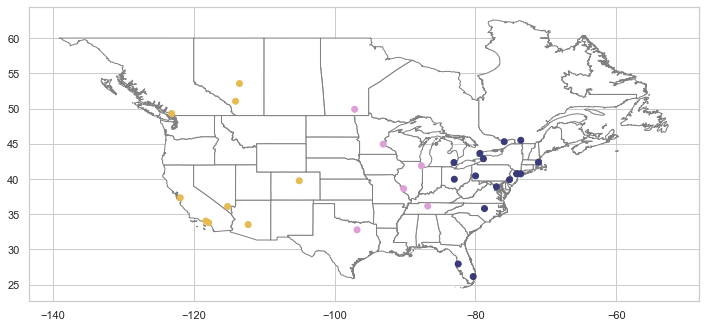

In [12]:
plot_clusters(us_can_gdf, arena_gdf, "arena_cluster")

### Adding Centroids to the data

In [13]:
centroid_gdf = gpd.GeoDataFrame(data=[f"Cluster{x}" for x in range(0, 3)], columns = ['Team_name'])

# making the centroids into points
centroid_gdf['geometry'] = [Point(coord[1], coord[0]) for coord in kmeans.cluster_centers_]
centroid_gdf['arena_cluster'] = [x for x in range(4, 7)]
centroid_gdf

,Team_name,geometry,arena_cluster
0,Cluster0,POINT (-77.51951 39.58365),4
1,Cluster1,POINT (-115.68339 40.93658),5
2,Cluster2,POINT (-91.95157 40.71575),6


In [14]:
# merging the two
arena_gdf_w_centroids = pd.concat([arena_gdf, centroid_gdf])

<AxesSubplot:>

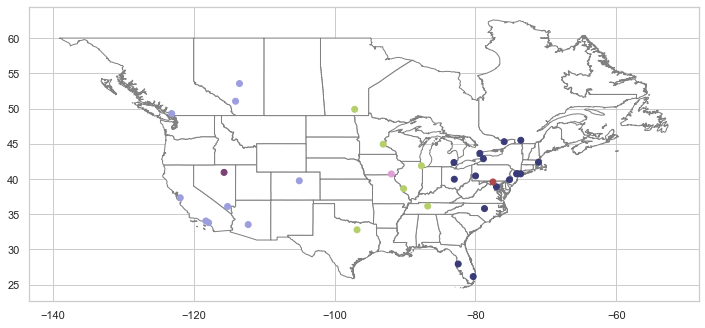

In [15]:
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
plot_clusters(us_can_gdf, arena_gdf_w_centroids, "arena_cluster")
# plt.savefig("pictures/arena_gdf_w_centroids.png", bbox_inches='tight', pad_inches=0.2)

### How many arenas are in each cluster?

In [16]:
# clusters: 0 = east coast, 1 = west coast, 2 = central
# more teams in east coast than west and central (least)
arena_gdf.arena_cluster.value_counts()

0    16
1     9
2     6
Name: arena_cluster, dtype: int64

## Minimum size of cluster - 3

<AxesSubplot:>

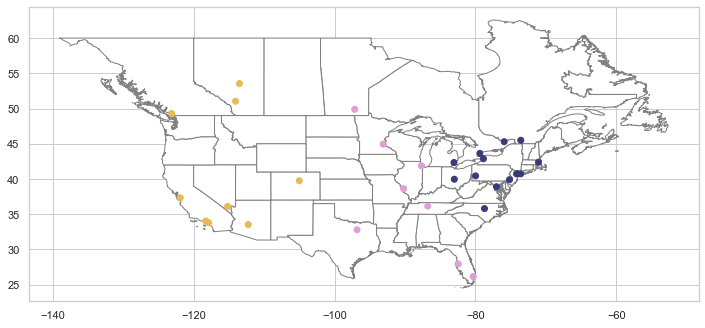

In [17]:
plot_clusters(us_can_gdf, arena_gdf, "arena_cluster_mink3")

In [18]:
# number of teams in each cluster
# more teams in east coast than west and central (least)
arena_gdf.arena_cluster_mink3.value_counts()

0    14
1     9
2     8
Name: arena_cluster_mink3, dtype: int64

## Minimum size of cluster - 4

<AxesSubplot:>

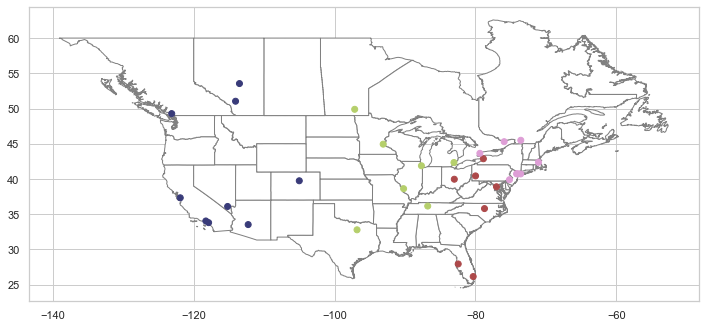

In [19]:
plot_clusters(us_can_gdf, arena_gdf, "arena_cluster_mink4")

In [20]:
# number of teams in each cluster
# more teams in west coast than west and central (least)
arena_gdf.arena_cluster_mink4.value_counts()

0    9
3    8
1    7
2    7
Name: arena_cluster_mink4, dtype: int64